# Tensaurus

This notebook reproduces the salient characteristics of the [Tensaurus](https://ieeexplore.ieee.org/document/9065579) accelerator.

## Imports

Import the necessary modules.

In [1]:
# HiFiber boilerplate

from fibertree_bootstrap import *

fibertree_bootstrap(style="tree", animation='movie')

# Compilation boilerplate

import os
import sys
sys.path.insert(0, "..")

from src import utils

Running bootstrap
The fibertree module is already installed and available to import


interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

## Compile from TeAAL Specification and Run

Below is the TeAAL specification for Tensaurus. To simulate the accelerator:
1. Compile it to HiFiber by running the cell, inserting a new cell
2. Replace the splitUniform with the uniform_slice function for rank I of tensor A
4. Run the new cell, which will
    - Execute the kernel; multiplying the above defined matrices
    - Generate visualizations of the actions of the kernel

Remember, if you are using large tensors, remove the spacetime specification to generate a kernel that does not produce videos. Outputs can still be checked below.

## Slice Partitioning Technique
The uniform slice partitioning technique is described in section 4: SPARSE FORMATS of the Tensaurus paper. In the section, the authors described the compressed interleaved sparse slice (CISS) storage format, which implements uniform slice partitioning to achieve a higher memory bandwidth compared to existing sparse tensor storage formats, including compressed sparse row (CSR), compressed sparse fiber (CSF), co-ordinate (COO), and their variants.

The implementation of the uniform_slice function is introduced below.

This is the fibertree for A_IJK before performing uniform slice partitioning.


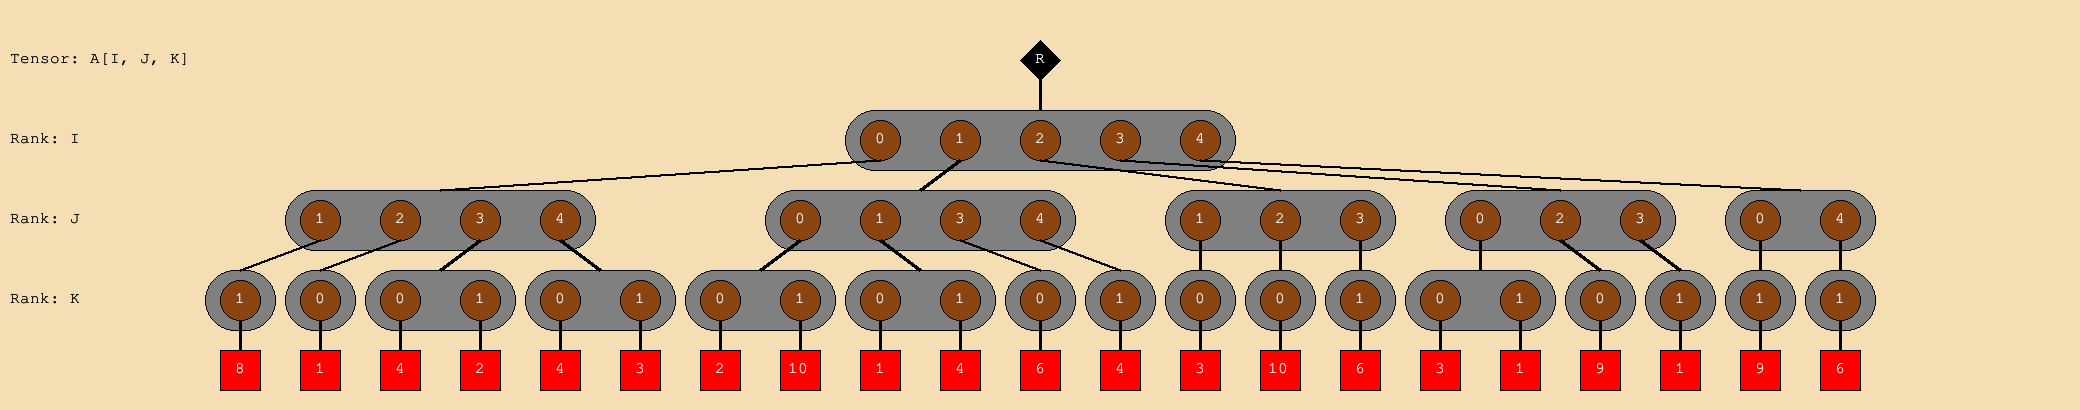



This is the fibertree for A_I1I0JK after performing uniform slice partitioning.


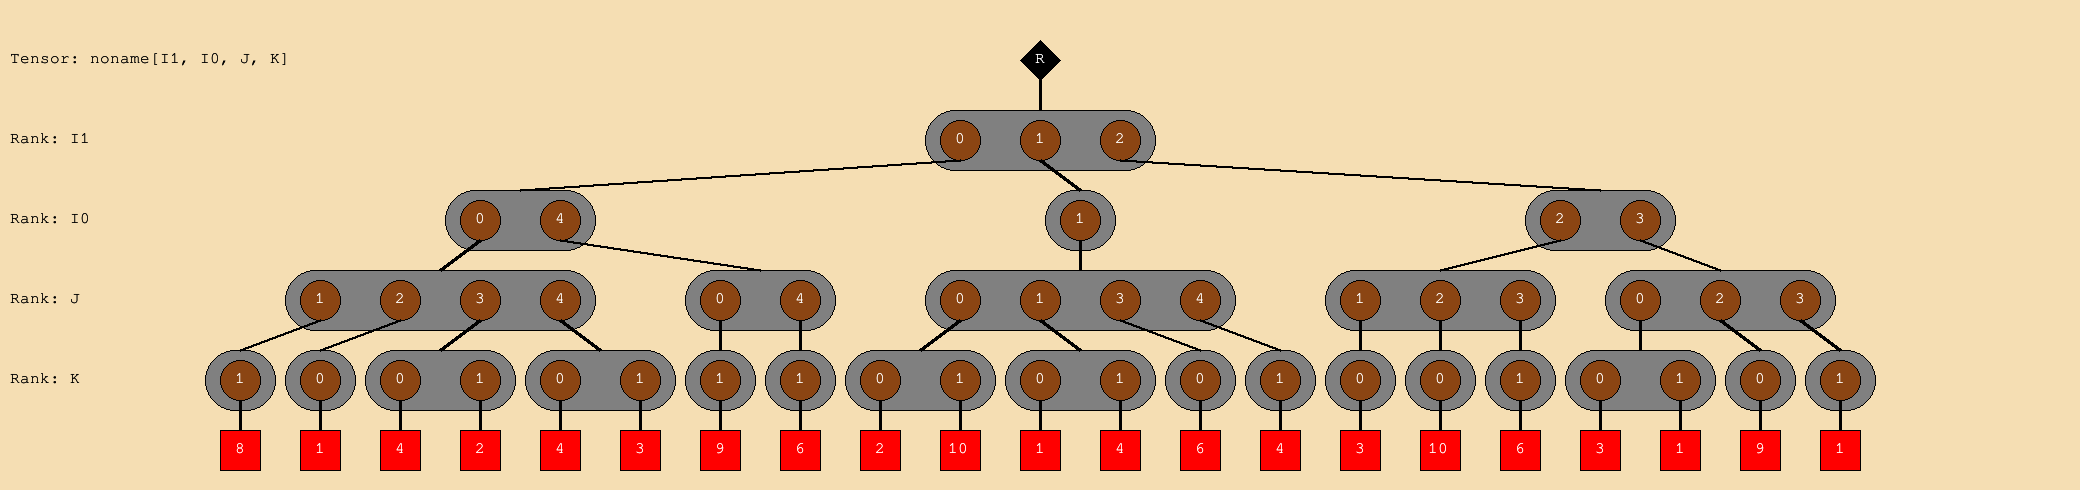

In [22]:
I = 5
J = 5
K = 2

density = [1, 0.8, 0.5]
seed = 5

A_IJK = Tensor.fromRandom(rank_ids=["I", "J", "K"], shape=[I, J, K], seed=seed, density=density, name="A")

print("This is the fibertree for A_IJK before performing uniform slice partitioning.")
displayTensor(A_IJK)
print("\n")

def total_nnz(A):
    """
    Returns the total non-zero value under each slice of the tensor A.
    """
    res = dict()
    a_i = A.getRoot()
    for i, a_j in a_i:
        res[i] = a_j.countValues()
    return res


def uniform_slice(numOfSlice, A):
    """
    Takes a 3-d tensor, A, and partitions it based on the number of slices, numOfSlice, specified by the user.
    The function returns the partitioned version of the tensor.
    """
    nnz = total_nnz(A)
    track = [0 for i in range(numOfSlice)]
    Z = Tensor(rank_ids=([A.getRankIds()[0] + '1', A.getRankIds()[0] + '0']  + A.getRankIds()[1:]))
    z_i1 = Z.getRoot()
    a_i = A.getRoot()
    for i, a_j in a_i:
        currSlice = track.index(min(track))
        z_j = z_i1.getPayloadRef(currSlice).getPayloadRef(i)
        z_j <<= a_j # Adds a_jk subtree under a specific element in I0 of the output tensor
        track[currSlice] += nnz[i]
    return Z

A_I1I0JK = uniform_slice(3, A_IJK)
print("This is the fibertree for A_I1I0JK after performing uniform slice partitioning.")
displayTensor(A_I1I0JK)

## Kernel: DMTTKRP and SpMTTKRP

### Initialization for DMTTKRP and SpMTTKRP
Initialize the input tensors. Tensor shapes and densities can be modified below.

**Warning:** Large tensors will overwhelm the video generation. Either:
1. Use small tensors; as a rule of thumb, fewer than 60 computes (e.g., multiplications) should be required.
2. Do not generate a video; remove the `spacetime` specification from the `mapping` before compiling.

**Note:** Remember to change the partitioning of tensor A_IJK and T_IJF2F1F0 along rank I from splitUniform to uniform_slice once the HiFiber for the TeAAL specification is generated to mimic the actual behavior of Tensaurus.

In [23]:
I = 4
J = 2
K = 2
F = 2

density = [0.8, 0.8, 0.9]
seed = 0

A_IJK = Tensor.fromRandom(rank_ids=["I", "J", "K"], shape=[I, J, K], seed=seed, density=density, name="A")
B_JF = Tensor.fromRandom(rank_ids=["J", "F"], shape=[J, F], seed=seed, density=[1, 1], name="B")
C_KF = Tensor.fromRandom(rank_ids=["K", "F"], shape=[K, F], seed=seed + 1, density=[1, 1], name="C")

Execute the following cell if you wish to visualize the tensor A_IJK, B_JF, and C_KF.

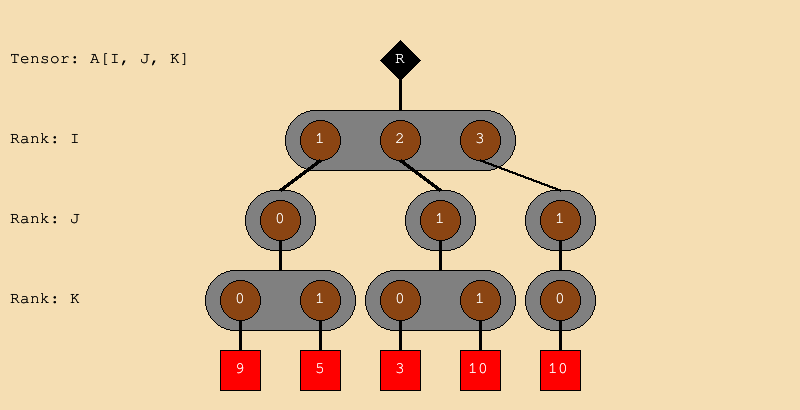

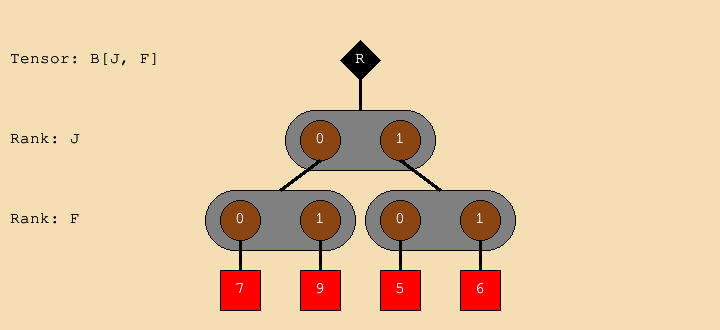

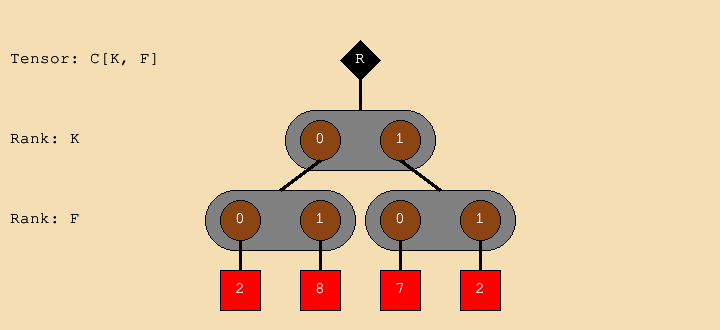

In [24]:
displayTensor(A_IJK)
displayTensor(B_JF)
displayTensor(C_KF)

### TeAAL Specification

In [25]:
yaml = """
einsum:
    declaration:
        A: [I, J, K]
        B: [J, F]
        C: [K, F]
        T: [I, J, F]
        Y: [I, F]
    expressions:
        - T[i, j, f] = A[i, j, k] * C[k, f]
        - Y[i, f] = T[i, j, f] * B[j, f]
mapping:
    rank-order:
        A: [I, J, K]
        B: [J, F]
        C: [K, F]
        T: [I, J, F]
        Y: [I, F]
    partitioning:
        T:
            I: [uniform_shape(8)]
            J: [uniform_shape(8)]
            K: [uniform_shape(8)]
            F: [uniform_shape(32), uniform_shape(4)]
        Y:
            I: [uniform_shape(8)]
            J: [uniform_shape(8)]
            F: [uniform_shape(32), uniform_shape(4)]
    loop-order:
        T: [I1, I0, F2, J1, K1, J0, K0, F1, F0]
        Y: [I1, I0, F2, J1, J0, F1, F0]
    spacetime:
        T:
            space: [I1, F1, F0]
            time: [I0, F2, J1, K1, J0, K0]
        Y:
            space: [I1, F1, F0]
            time: [ I0, F2, J1, J0]
"""

utils.compile(yaml)

In [5]:
# Autogenerated HiFiber

T_I1I0F2J1J0F1F0 = Tensor(rank_ids=["I1", "I0", "F2", "J1", "J0", "F1", "F0"], name="T")
tmp0 = A_IJK
tmp1 = uniform_slice(8, tmp0) # Rather than splitUniform, uniform_slice is used to mimic the CISS sparse storage format.
A_I1I0JK = tmp1
A_I1I0JK.setRankIds(rank_ids=["I1", "I0", "J", "K"])
tmp2 = A_I1I0JK
tmp3 = tmp2.splitUniform(8, depth=2)
A_I1I0J1J0K = tmp3
A_I1I0J1J0K.setRankIds(rank_ids=["I1", "I0", "J1", "J0", "K"])
tmp4 = A_I1I0J1J0K
tmp5 = tmp4.splitUniform(8, depth=4)
A_I1I0J1J0K1K0 = tmp5
A_I1I0J1J0K1K0.setRankIds(rank_ids=["I1", "I0", "J1", "J0", "K1", "K0"])
tmp6 = C_KF
tmp7 = tmp6.splitUniform(32, depth=1)
tmp8 = tmp7.splitUniform(4, depth=2)
C_KF2F1F0 = tmp8
C_KF2F1F0.setRankIds(rank_ids=["K", "F2", "F1", "F0"])
tmp9 = C_KF2F1F0
tmp10 = tmp9.splitUniform(8, depth=0)
C_K1K0F2F1F0 = tmp10
C_K1K0F2F1F0.setRankIds(rank_ids=["K1", "K0", "F2", "F1", "F0"])
t_i1 = T_I1I0F2J1J0F1F0.getRoot()
A_I1I0J1K1J0K0 = A_I1I0J1J0K1K0.swizzleRanks(rank_ids=["I1", "I0", "J1", "K1", "J0", "K0"])
C_F2K1K0F1F0 = C_K1K0F2F1F0.swizzleRanks(rank_ids=["F2", "K1", "K0", "F1", "F0"])
a_i1 = A_I1I0J1K1J0K0.getRoot()
c_f2 = C_F2K1K0F1F0.getRoot()
canvas = createCanvas(A_I1I0J1K1J0K0, C_F2K1K0F1F0, T_I1I0F2J1J0F1F0)
for i1_pos, (i1, (t_i0, a_i0)) in enumerate(t_i1 << a_i1):
    for i0_pos, (i0, (t_f2, a_j1)) in enumerate(t_i0 << a_i0):
        for f2_pos, (f2, (t_j1, c_k1)) in enumerate(t_f2 << c_f2):
            for j1_pos, (j1, (t_j0, a_k1)) in enumerate(t_j1 << a_j1):
                for k1_pos, (k1, (a_j0, c_k0)) in enumerate(a_k1 & c_k1):
                    for j0_pos, (j0, (t_f1, a_k0)) in enumerate(t_j0 << a_j0):
                        for k0_pos, (k0, (a_val, c_f1)) in enumerate(a_k0 & c_k0):
                            for f1_pos, (f1, (t_f0, c_f0)) in enumerate(t_f1 << c_f1):
                                for f0_pos, (f0, (t_ref, c_val)) in enumerate(t_f0 << c_f0):
                                    t_ref += a_val * c_val
                                    canvas.addActivity((i1, i0, j1, k1, j0, k0), (f2, k1, k0, f1, f0), (i1, i0, f2, j1, j0, f1, f0), spacetime=((i1_pos, f1_pos, f0_pos), (i0_pos, f2_pos, j1_pos, k1_pos, j0_pos, k0_pos)))
tmp11 = T_I1I0F2J1J0F1F0
tmp12 = tmp11.swizzleRanks(rank_ids=["I1", "I0", "J1", "J0", "F2", "F1", "F0"])
tmp13 = tmp12.mergeRanks(depth=2, levels=1, coord_style="absolute")
tmp14 = tmp13.mergeRanks(depth=0, levels=1, coord_style="absolute")
tmp15 = tmp14.mergeRanks(depth=2, levels=2, coord_style="absolute")
tmp15.setRankIds(rank_ids=["I", "J", "F"])
T_IJF = tmp15
displayCanvas(canvas)
Y_I1I0F2F1F0 = Tensor(rank_ids=["I1", "I0", "F2", "F1", "F0"], name="Y")
tmp16 = T_IJF
tmp17 = tmp16.splitUniform(32, depth=2)
tmp18 = tmp17.splitUniform(4, depth=3)
T_IJF2F1F0 = tmp18
T_IJF2F1F0.setRankIds(rank_ids=["I", "J", "F2", "F1", "F0"])
tmp19 = T_IJF2F1F0
tmp20 = uniform_slice(8, tmp19) # Rather than splitUniform, uniform_slice is used to mimic the CISS sparse storage format.
T_I1I0JF2F1F0 = tmp20
T_I1I0JF2F1F0.setRankIds(rank_ids=["I1", "I0", "J", "F2", "F1", "F0"])
tmp21 = T_I1I0JF2F1F0
tmp22 = tmp21.splitUniform(8, depth=2)
T_I1I0J1J0F2F1F0 = tmp22
T_I1I0J1J0F2F1F0.setRankIds(rank_ids=["I1", "I0", "J1", "J0", "F2", "F1", "F0"])
tmp23 = B_JF
tmp24 = tmp23.splitUniform(32, depth=1)
tmp25 = tmp24.splitUniform(4, depth=2)
B_JF2F1F0 = tmp25
B_JF2F1F0.setRankIds(rank_ids=["J", "F2", "F1", "F0"])
tmp26 = B_JF2F1F0
tmp27 = tmp26.splitUniform(8, depth=0)
B_J1J0F2F1F0 = tmp27
B_J1J0F2F1F0.setRankIds(rank_ids=["J1", "J0", "F2", "F1", "F0"])
y_i1 = Y_I1I0F2F1F0.getRoot()
T_I1I0F2J1J0F1F0 = T_I1I0J1J0F2F1F0.swizzleRanks(rank_ids=["I1", "I0", "F2", "J1", "J0", "F1", "F0"])
B_F2J1J0F1F0 = B_J1J0F2F1F0.swizzleRanks(rank_ids=["F2", "J1", "J0", "F1", "F0"])
t_i1 = T_I1I0F2J1J0F1F0.getRoot()
b_f2 = B_F2J1J0F1F0.getRoot()
canvas = createCanvas(T_I1I0F2J1J0F1F0, B_F2J1J0F1F0, Y_I1I0F2F1F0)
for i1_pos, (i1, (y_i0, t_i0)) in enumerate(y_i1 << t_i1):
    for i0_pos, (i0, (y_f2, t_f2)) in enumerate(y_i0 << t_i0):
        for f2_pos, (f2, (y_f1, (t_j1, b_j1))) in enumerate(y_f2 << (t_f2 & b_f2)):
            for j1_pos, (j1, (t_j0, b_j0)) in enumerate(t_j1 & b_j1):
                for j0_pos, (j0, (t_f1, b_f1)) in enumerate(t_j0 & b_j0):
                    for f1_pos, (f1, (y_f0, (t_f0, b_f0))) in enumerate(y_f1 << (t_f1 & b_f1)):
                        for f0_pos, (f0, (y_ref, (t_val, b_val))) in enumerate(y_f0 << (t_f0 & b_f0)):
                            y_ref += t_val * b_val
                            canvas.addActivity((i1, i0, f2, j1, j0, f1, f0), (f2, j1, j0, f1, f0), (i1, i0, f2, f1, f0), spacetime=((i1_pos, f1_pos, f0_pos), (i0_pos, f2_pos, j1_pos, j0_pos)))
tmp28 = Y_I1I0F2F1F0
tmp29 = tmp28.mergeRanks(depth=0, levels=1, coord_style="absolute")
tmp30 = tmp29.mergeRanks(depth=1, levels=2, coord_style="absolute")
tmp30.setRankIds(rank_ids=["I", "F"])
Y_IF = tmp30
displayCanvas(canvas)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

### Check Results

Check that above code (generated or provided) computes the correct result.
**Note**: Should be used after executing the HiFiber loopnest (one of the above cells).

In [26]:
utils.check_MTTKRP(A_IJK, B_JF, C_KF, Y_IF)

Result correct? True


## Kernel: DTTMc and SpTTMc

**Note:** Remember to change the partitioning of tensor I from uniform_shape to uniform_slice once the HiFiber for the TeAAL specification is generated.

### Initialization for DTTMc and SpTTMc
Initialize the input tensors. Tensor shapes and densities can be modified below.

**Warning:** Large tensors will overwhelm the video generation. Either:
1. Use small tensors; as a rule of thumb, fewer than 60 computes (e.g., multiplications) should be required.
2. Do not generate a video; remove the `spacetime` specification from the `mapping` before compiling.

**Note:** Remember to change the partitioning of tensor A_I1I0JK and T_IJU2U1U0 along rank I from splitUniform to uniform_slice once the HiFiber for the TeAAL specification is generated to mimic the actual behavior of Tensaurus.

In [31]:
I = 4
J = 2
K = 2
V = 2
U = 2

density = [0.8, 0.8, 0.9]
seed = 0

A_IJK = Tensor.fromRandom(rank_ids=["I", "J", "K"], shape=[I, J, K], seed=seed, density=density, name="A")
B_JV = Tensor.fromRandom(rank_ids=["J", "V"], shape=[J, V], seed=seed, density=[1, 1], name="B")
C_KU = Tensor.fromRandom(rank_ids=["K", "U"], shape=[K, U], seed=seed + 1, density=[1, 1], name="C")

Execute the following cell if you wish to visualize the tensor A_IJK, B_JV, and C_KU.

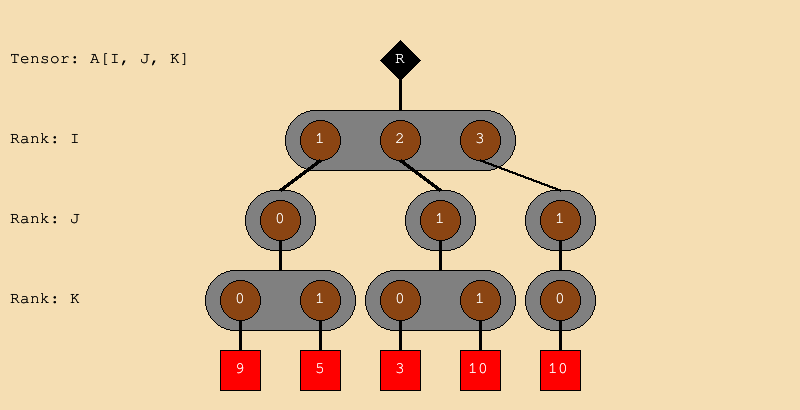

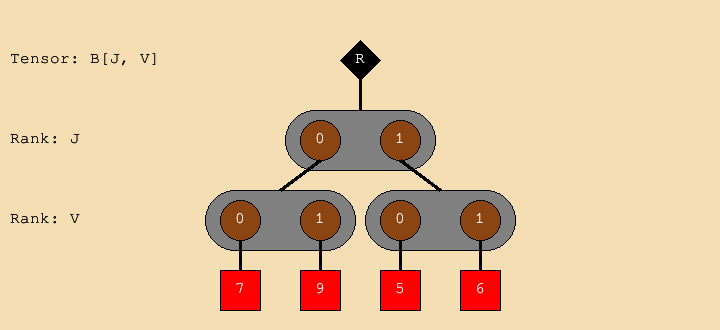

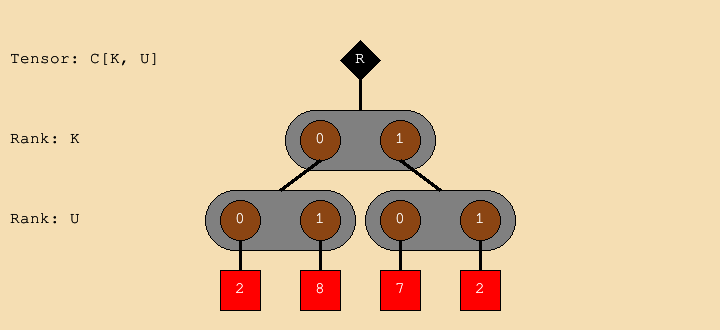

In [32]:
displayTensor(A_IJK)
displayTensor(B_JV)
displayTensor(C_KU)

### TeAAL Specification

In [33]:
yaml = """
einsum:
    declaration:
        A: [I, J, K]
        B: [J, V]
        C: [K, U]
        T: [I, J, U]
        Y: [I, V, U]
    expressions:
        - T[i, j, u] = A[i, j, k] * C[k, u]
        - Y[i, v, u] = T[i, j, u] * B[j, v]
mapping:
    rank-order:
        A: [I, J, K]
        B: [J, V]
        C: [K, U]
        T: [I, J, U]
        Y: [I, V, U]
    partitioning:
        T: 
            I: [uniform_shape(8)]
            K: [uniform_shape(8)]
            U: [uniform_shape(32), uniform_shape(4)]
        Y:
            I: [uniform_shape(8)]
            U: [uniform_shape(32), uniform_shape(4)]
            V: [uniform_shape(8)]
    loop-order:
        T: [I1, I0, J, U2, K1, K0, U1, U0]
        Y: [I1, I0, J, V1, U2, V0, U1, U0]
    spacetime:
        T:
            space: [I1, U1, U0]
            time: [I0, J, U2, K1, K0]
        Y:
            space: [I1, U1, U0]
            time: [I0, J, V1, U2, V0]
"""

utils.compile(yaml)

In [34]:
# Autogenerated HiFiber

T_I1I0JU2U1U0 = Tensor(rank_ids=["I1", "I0", "J", "U2", "U1", "U0"], name="T")
tmp0 = A_IJK
tmp1 = uniform_slice(8, tmp0) # Rather than splitUniform, uniform_slice is used to mimic the CISS sparse storage format.
A_I1I0JK = tmp1
A_I1I0JK.setRankIds(rank_ids=["I1", "I0", "J", "K"])
tmp2 = A_I1I0JK
tmp3 = tmp2.splitUniform(8, depth=3)
A_I1I0JK1K0 = tmp3
A_I1I0JK1K0.setRankIds(rank_ids=["I1", "I0", "J", "K1", "K0"])
tmp4 = C_KU
tmp5 = tmp4.splitUniform(32, depth=1)
tmp6 = tmp5.splitUniform(4, depth=2)
C_KU2U1U0 = tmp6
C_KU2U1U0.setRankIds(rank_ids=["K", "U2", "U1", "U0"])
tmp7 = C_KU2U1U0
tmp8 = tmp7.splitUniform(8, depth=0)
C_K1K0U2U1U0 = tmp8
C_K1K0U2U1U0.setRankIds(rank_ids=["K1", "K0", "U2", "U1", "U0"])
t_i1 = T_I1I0JU2U1U0.getRoot()
C_U2K1K0U1U0 = C_K1K0U2U1U0.swizzleRanks(rank_ids=["U2", "K1", "K0", "U1", "U0"])
a_i1 = A_I1I0JK1K0.getRoot()
c_u2 = C_U2K1K0U1U0.getRoot()
canvas = createCanvas(A_I1I0JK1K0, C_U2K1K0U1U0, T_I1I0JU2U1U0)
for i1_pos, (i1, (t_i0, a_i0)) in enumerate(t_i1 << a_i1):
    for i0_pos, (i0, (t_j, a_j)) in enumerate(t_i0 << a_i0):
        for j_pos, (j, (t_u2, a_k1)) in enumerate(t_j << a_j):
            for u2_pos, (u2, (t_u1, c_k1)) in enumerate(t_u2 << c_u2):
                for k1_pos, (k1, (a_k0, c_k0)) in enumerate(a_k1 & c_k1):
                    for k0_pos, (k0, (a_val, c_u1)) in enumerate(a_k0 & c_k0):
                        for u1_pos, (u1, (t_u0, c_u0)) in enumerate(t_u1 << c_u1):
                            for u0_pos, (u0, (t_ref, c_val)) in enumerate(t_u0 << c_u0):
                                t_ref += a_val * c_val
                                canvas.addActivity((i1, i0, j, k1, k0), (u2, k1, k0, u1, u0), (i1, i0, j, u2, u1, u0), spacetime=((i1_pos, u1_pos, u0_pos), (i0_pos, j_pos, u2_pos, k1_pos, k0_pos)))
tmp9 = T_I1I0JU2U1U0
tmp10 = tmp9.mergeRanks(depth=0, levels=1, coord_style="absolute")
tmp11 = tmp10.mergeRanks(depth=2, levels=2, coord_style="absolute")
tmp11.setRankIds(rank_ids=["I", "J", "U"])
T_IJU = tmp11
displayCanvas(canvas)
Y_I1I0V1U2V0U1U0 = Tensor(rank_ids=["I1", "I0", "V1", "U2", "V0", "U1", "U0"], name="Y")
tmp12 = T_IJU
tmp13 = tmp12.splitUniform(32, depth=2)
tmp14 = tmp13.splitUniform(4, depth=3)
T_IJU2U1U0 = tmp14
T_IJU2U1U0.setRankIds(rank_ids=["I", "J", "U2", "U1", "U0"])
tmp15 = T_IJU2U1U0
tmp16 = uniform_slice(8, tmp15) # Rather than splitUniform, uniform_slice is used to mimic the CISS sparse storage format.
T_I1I0JU2U1U0 = tmp16
T_I1I0JU2U1U0.setRankIds(rank_ids=["I1", "I0", "J", "U2", "U1", "U0"])
tmp17 = B_JV
tmp18 = tmp17.splitUniform(8, depth=1)
B_JV1V0 = tmp18
B_JV1V0.setRankIds(rank_ids=["J", "V1", "V0"])
y_i1 = Y_I1I0V1U2V0U1U0.getRoot()
t_i1 = T_I1I0JU2U1U0.getRoot()
b_j = B_JV1V0.getRoot()
canvas = createCanvas(T_I1I0JU2U1U0, B_JV1V0, Y_I1I0V1U2V0U1U0)
for i1_pos, (i1, (y_i0, t_i0)) in enumerate(y_i1 << t_i1):
    for i0_pos, (i0, (y_v1, t_j)) in enumerate(y_i0 << t_i0):
        for j_pos, (j, (t_u2, b_v1)) in enumerate(t_j & b_j):
            for v1_pos, (v1, (y_u2, b_v0)) in enumerate(y_v1 << b_v1):
                for u2_pos, (u2, (y_v0, t_u1)) in enumerate(y_u2 << t_u2):
                    for v0_pos, (v0, (y_u1, b_val)) in enumerate(y_v0 << b_v0):
                        for u1_pos, (u1, (y_u0, t_u0)) in enumerate(y_u1 << t_u1):
                            for u0_pos, (u0, (y_ref, t_val)) in enumerate(y_u0 << t_u0):
                                y_ref += t_val * b_val
                                canvas.addActivity((i1, i0, j, u2, u1, u0), (j, v1, v0), (i1, i0, v1, u2, v0, u1, u0), spacetime=((i1_pos, u1_pos, u0_pos), (i0_pos, j_pos, v1_pos, u2_pos, v0_pos)))
tmp19 = Y_I1I0V1U2V0U1U0
tmp20 = tmp19.swizzleRanks(rank_ids=["I1", "I0", "V1", "V0", "U2", "U1", "U0"])
tmp21 = tmp20.mergeRanks(depth=0, levels=1, coord_style="absolute")
tmp22 = tmp21.mergeRanks(depth=3, levels=2, coord_style="absolute")
tmp23 = tmp22.mergeRanks(depth=1, levels=1, coord_style="absolute")
tmp23.setRankIds(rank_ids=["I", "V", "U"])
Y_IVU = tmp23
displayCanvas(canvas)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

### Check Results

Check that above code (generated or provided) computes the correct result.
**Note**: Should be used after executing the HiFiber loopnest (one of the above cells).

In [35]:
utils.check_TTMc(A_IJK, B_JV, C_KU, Y_IVU)

Result correct? True


## Kernel: GEMM and SpMM

**Note:**
1. The dataflow of GEMM and SpMM for Tensaurus is relatively simple because the authors assume the operand matrix is dense while the input matrix A can be dense or sparse.
2. Temporary shift registers are not used for GEMM and SpMM.

## Initialization for GEMM and SpMM
Initialize the input tensors. Tensor shapes and densities can be modified below.

**Warning:** Large tensors will overwhelm the video generation. Either:
1. Use small tensors; as a rule of thumb, fewer than 60 computes (e.g., multiplications) should be required.
2. Do not generate a video; remove the `spacetime` specification from the `mapping` before compiling.

**Note:** Remember to change the partitioning of tensor A_IJ along rank I from splitUniform to uniform_slice once the HiFiber for the TeAAL specification is generated to mimic the actual behavior of Tensaurus.

In [36]:
I = 4
J = 4
K = 4

density = [0.8, 0.8]
seed = 0

A_IJ = Tensor.fromRandom(rank_ids=["I", "J"], shape=[I, J], seed=seed, density=density, name="A")
B_JK = Tensor.fromRandom(rank_ids=["J", "K"], shape=[J, K], seed=seed + 1, density=[1,1], name="B")

Execute the following cell if you wish to visualize the tensor A_IJ and B_JK.

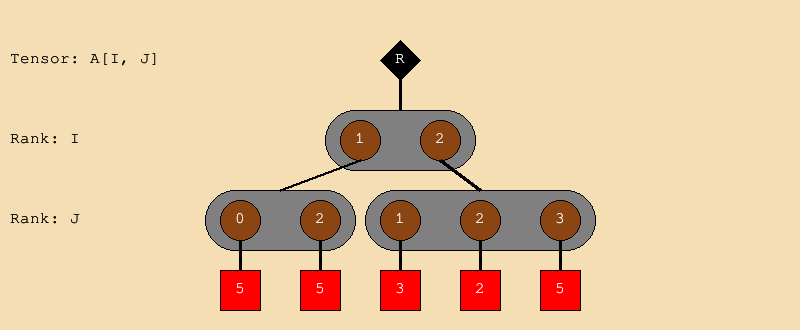

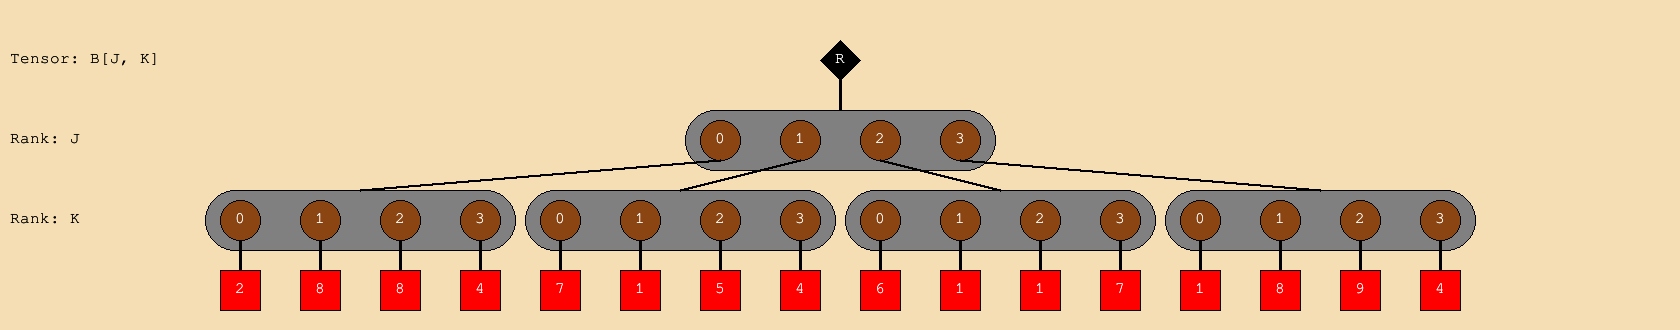

In [37]:
displayTensor(A_IJ)
displayTensor(B_JK)

In [38]:
yaml = """
einsum:
    declaration:
        A: [I, J]
        B: [J, K]
        Y: [I, K]
    expressions:
        - Y[i, k] = A[i, j] * B[j, k]
mapping:
    rank-order:
        A: [I, J]
        B: [J, K]
        Y: [I, K]
    partitioning:
        Y:
            I: [uniform_shape(8)]
            K: [uniform_shape(32), uniform_shape(4)]
    loop-order:
        Y: [I1, I0, K2, J, K1, K0]
    spacetime:
        Y:
            space: [I1, K1, K0]
            time: [I0, K2, J]
"""

utils.compile(yaml)

In [39]:
# Autogenerated HiFiber

Y_I1I0K2K1K0 = Tensor(rank_ids=["I1", "I0", "K2", "K1", "K0"], name="Y")
tmp0 = A_IJ
tmp1 = uniform_slice(8, tmp0) # Rather than splitUniform, uniform_slice is used to mimic the CISS sparse storage format.
A_I1I0J = tmp1
A_I1I0J.setRankIds(rank_ids=["I1", "I0", "J"])
tmp2 = B_JK
tmp3 = tmp2.splitUniform(32, depth=1)
tmp4 = tmp3.splitUniform(4, depth=2)
B_JK2K1K0 = tmp4
B_JK2K1K0.setRankIds(rank_ids=["J", "K2", "K1", "K0"])
y_i1 = Y_I1I0K2K1K0.getRoot()
B_K2JK1K0 = B_JK2K1K0.swizzleRanks(rank_ids=["K2", "J", "K1", "K0"])
a_i1 = A_I1I0J.getRoot()
b_k2 = B_K2JK1K0.getRoot()
canvas = createCanvas(A_I1I0J, B_K2JK1K0, Y_I1I0K2K1K0)
for i1_pos, (i1, (y_i0, a_i0)) in enumerate(y_i1 << a_i1):
    for i0_pos, (i0, (y_k2, a_j)) in enumerate(y_i0 << a_i0):
        for k2_pos, (k2, (y_k1, b_j)) in enumerate(y_k2 << b_k2):
            for j_pos, (j, (a_val, b_k1)) in enumerate(a_j & b_j):
                for k1_pos, (k1, (y_k0, b_k0)) in enumerate(y_k1 << b_k1):
                    for k0_pos, (k0, (y_ref, b_val)) in enumerate(y_k0 << b_k0):
                        y_ref += a_val * b_val
                        canvas.addActivity((i1, i0, j), (k2, j, k1, k0), (i1, i0, k2, k1, k0), spacetime=((i1_pos, k1_pos, k0_pos), (i0_pos, k2_pos, j_pos)))
tmp5 = Y_I1I0K2K1K0
tmp6 = tmp5.mergeRanks(depth=2, levels=2, coord_style="absolute")
tmp7 = tmp6.mergeRanks(depth=0, levels=1, coord_style="absolute")
tmp7.setRankIds(rank_ids=["I", "K"])
Y_IK = tmp7
displayCanvas(canvas)

  0%|          | 0/5 [00:00<?, ?it/s]

### Check Results

Check that above code (generated or provided) computes the correct result.
**Note**: Should be used after executing the HiFiber loopnest (one of the above cells).

In [40]:
utils.check_matrix_matrix_mul(A_IJ, B_JK, Y_IK)

Result correct? True


## Kernel: GEMV and SpMV

**Note:**
1. The dataflow of GEMV and SpMV for Tensaurus is relatively simple because the authors assume that the operand vector is dense while the input matrix A can be dense or sparse.
2. Temporary shift registers are not used for GEMV and SpMV. Only one output shift register is utilized.

## Initialization for GEMV and SpMV
Initialize the input tensors. Tensor shapes and densities can be modified below.

**Warning:** Large tensors will overwhelm the video generation. Either:
1. Use small tensors; as a rule of thumb, fewer than 60 computes (e.g., multiplications) should be required.
2. Do not generate a video; remove the `spacetime` specification from the `mapping` before compiling.

**Note:** Remember to change the partitioning of tensor I from uniform_shape to uniform_slice once the HiFiber for the TeAAL specification is generated to mimic the behavior of Tensaurus.

In [41]:
I = 4
J = 4

densityA = [0.9, 0.9]
seed = 0

A_IJ = Tensor.fromRandom(rank_ids=["I", "J"], shape=[I, J], seed=seed, density=densityA, name="A")
B_J = Tensor.fromRandom(rank_ids=["J"], shape=[J], seed=seed + 1, density=[1], name="B")

Execute the following cell if you wish to visualize the tensor A_IJ and B_J.

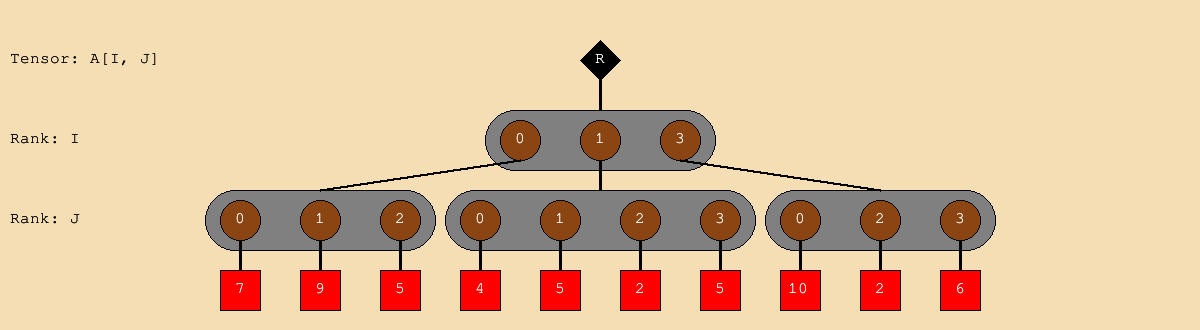

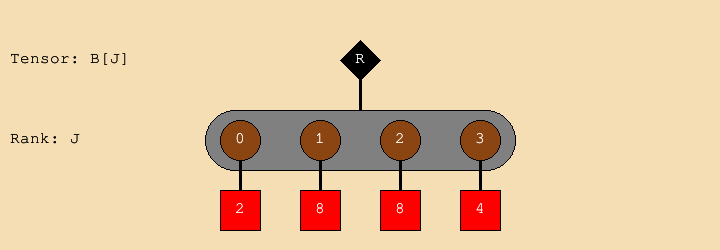

In [42]:
displayTensor(A_IJ)
displayTensor(B_J)

In [103]:
yaml = """
einsum:
    declaration:
        A: [I, J]
        B: [J]
        Y: [I]
    expressions:
        - Y[i] = A[i, j] * B[j]
mapping:
    rank-order:
        A: [I, J]
        B: [J]
        Y: [I]
    partitioning:
        Y:
            I: [uniform_shape(8)]
    loop-order:
        Y: [I1, I0, J]
    spacetime:
        Y:
            space: [I1]
            time: [I0, J]
"""

utils.compile(yaml)

In [43]:
# Autogenerated HiFiber

Y_I1I0 = Tensor(rank_ids=["I1", "I0"], name="Y")
tmp0 = A_IJ
tmp1 = uniform_slice(8, tmp0) # Rather than splitUniform, uniform_slice is used to mimic the CISS sparse storage format.
A_I1I0J = tmp1
A_I1I0J.setRankIds(rank_ids=["I1", "I0", "J"])
y_i1 = Y_I1I0.getRoot()
b_j = B_J.getRoot()
a_i1 = A_I1I0J.getRoot()
canvas = createCanvas(A_I1I0J, B_J, Y_I1I0)
for i1_pos, (i1, (y_i0, a_i0)) in enumerate(y_i1 << a_i1):
    for i0_pos, (i0, (y_ref, a_j)) in enumerate(y_i0 << a_i0):
        for j_pos, (j, (a_val, b_val)) in enumerate(a_j & b_j):
            y_ref += a_val * b_val
            canvas.addActivity((i1, i0, j), (j,), (i1, i0), spacetime=((i1_pos,), (i0_pos, j_pos)))
tmp2 = Y_I1I0
tmp3 = tmp2.mergeRanks(depth=0, levels=1, coord_style="absolute")
tmp3.setRankIds(rank_ids=["I"])
Y_I = tmp3
displayCanvas(canvas)

  0%|          | 0/6 [00:00<?, ?it/s]

### Check Results

Check that above code (generated or provided) computes the correct result.
**Note**: Should be used after executing the HiFiber loopnest (one of the above cells).

In [44]:
utils.check_matrix_vector_mul(A_IJ, B_J, Y_I)

Result correct? True
